In [3]:
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA

In [ ]:
#create a function to calculate the RSI
def calculate_rsi_ta(data):
    """
    This function calculates the RSI of the data
    :param data: pandas dataframe with the data
    :return data: pandas dataframe with the RSI
    """
    data['rsi'] = TA.RSI(data,14)
    return data



RSI

In [28]:
def calculate_rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = [np.nan] * (n - 1) + [100. - 100. / (1. + rs)]

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # Cambio actual
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n
        rs = up / down
        rsi.append(100. - 100. / (1. + rs))

    return rsi

In [37]:
import yfinance as yf
import numpy as np


data = yf.download('GOOG', start='2010-01-01', end= '2024-01-01',interval="1d")
prices = np.array(data['Adj Close'].values)
dates = np.array(data.index.values).astype('datetime64[ns]')
data['rsi'] = calculate_rsi(prices)
data.fillna(0, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [39]:
data['rsi']

Date
2014-03-27     0.000000
2014-03-28     0.000000
2014-03-31     0.000000
2014-04-01     0.000000
2014-04-02     0.000000
                ...    
2023-12-22    64.953258
2023-12-26    65.115855
2023-12-27    60.916000
2023-12-28    60.429335
2023-12-29    59.313041
Name: rsi, Length: 2458, dtype: float64

## Enviroment

In [102]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Adj Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['rsi']].to_numpy()[start:end]
    return prices, signal_features

In [44]:
class customEnv(StocksEnv):
    """
    Custom Environment for RL trading
    """
    _process_data = add_signals
env = customEnv(df=data, window_size=14, frame_bound=(14,100))
    

train

In [49]:
from stable_baselines3.common.vec_env import DummyVecEnv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf


env_maker = lambda: env
env_train = DummyVecEnv([env_maker])

In [55]:
from stable_baselines3 import A2C

model = A2C('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=100000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 603      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0.0168   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0228  |
|    value_loss         | 0.0231   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 604      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | -0.0733  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.195   |
|    value_loss     

Evaluation

In [138]:
env_test = customEnv(df=data, window_size=14, frame_bound=(15, 300))
obs,_ = env_test.reset()

while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards,_, done,  info= env_test.step(action)
    print(rewards)
    if done:
        print("info",info)
        break

0
0.30865478515625
0
0
0
0
0.03789520263671875
0
0.2338581085205078
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.021440505981445312
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.2338581085205078
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
info {'total_reward': 0.8357067108154297, 'total_profit': 0.957744030408383, 'position': <Positions.Short: 0>}


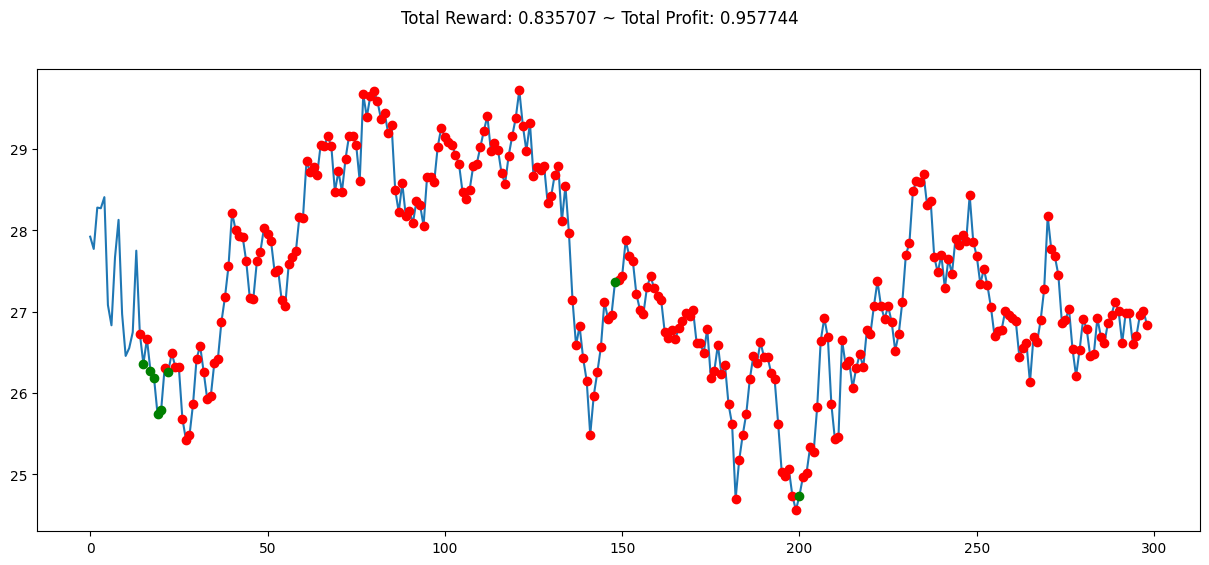

In [139]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.cla()
env_test.render_all()
plt.show()

## ELSE

In [85]:
env_test.step([2])

(array([[42.90572383],
        [41.18560508],
        [45.41570043],
        [44.84428623],
        [41.58389845],
        [50.6287522 ],
        [50.53785334],
        [49.6733183 ],
        [55.72457154],
        [58.62552725],
        [56.61125879],
        [55.63836965],
        [54.90352122],
        [52.71871221]]),
 0,
 False,
 False,
 {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>})

In [3]:

rsi = calculate_rsi(prices)



[*********************100%%**********************]  1 of 1 completed


## Enviroment